In [45]:
import pandas as pd
import numpy as np

final_model_df = pd.read_csv("../data/final_model_data.csv")


In [46]:
import numpy as np

# Convert championship_score into probability distribution
final_model_df['race_win_prob'] = (
    final_model_df['championship_score'] /
    final_model_df['championship_score'].sum()
)

print(final_model_df[['driver_id', 'race_win_prob']].head())


        driver_id  race_win_prob
0  max_verstappen       0.054901
1           perez       0.054578
2         leclerc       0.048105
3         tsunoda       0.047039
4          norris       0.046312


In [47]:
points_system = [25,18,15,12,10,8,6,4,2,1]


In [48]:
def simulate_season(drivers_df, races=24):
    
    drivers = drivers_df['driver_id'].values
    probs = drivers_df['race_win_prob'].values
    
    season_points = {driver: 0 for driver in drivers}
    
    for _ in range(races):
        
        # Sample full finishing order
        finishing_order = np.random.choice(
            drivers,
            size=len(drivers),
            replace=False,
            p=probs
        )
        
        # Assign points to top 10
        for i in range(min(10, len(finishing_order))):
            season_points[finishing_order[i]] += points_system[i]
    
    champion = max(season_points, key=season_points.get)
    return champion


In [49]:
from collections import Counter

simulations = 10000
champions = []

for _ in range(simulations):
    champ = simulate_season(final_model_df)
    champions.append(champ)

champion_counts = Counter(champions)


In [50]:
import pandas as pd

championship_results = pd.DataFrame.from_dict(
    champion_counts,
    orient='index',
    columns=['wins']
).reset_index()

championship_results.columns = ['driver_id', 'wins']

championship_results['championship_probability'] = (
    championship_results['wins'] / simulations
)

championship_results = championship_results.sort_values(
    by='championship_probability',
    ascending=False
)

print(championship_results.head(10))


         driver_id  wins  championship_probability
0   max_verstappen  1742                    0.1742
7            perez  1694                    0.1694
5          leclerc   942                    0.0942
8          tsunoda   874                    0.0874
10          norris   818                    0.0818
4          piastri   731                    0.0731
2         hamilton   715                    0.0715
3          russell   647                    0.0647
12       antonelli   410                    0.0410
16          vettel   242                    0.0242


In [51]:
drivers = pd.read_csv("c:/Users/DELL/Downloads/archive (11)/drivers.csv")

drivers['full_name'] = drivers['givenName'] + " " + drivers['familyName']


In [52]:
championship_results = championship_results.merge(
    drivers[['driver_id', 'full_name']],
    on='driver_id',
    how='left'
)


In [53]:
championship_results = championship_results.sort_values(
    by='championship_probability',
    ascending=False
)


In [54]:
championship_results['championship_probability']*= 100

In [55]:
championship_results[['full_name', 'championship_probability']].head(10)

,full_name,championship_probability
0,Max Verstappen,17.42
1,Sergio Pérez,16.94
2,Charles Leclerc,9.42
3,Yuki Tsunoda,8.74
4,Lando Norris,8.18
5,Oscar Piastri,7.31
6,Lewis Hamilton,7.15
7,George Russell,6.47
8,Andrea Kimi Antonelli,4.10
9,Sebastian Vettel,2.42


In [56]:
import sys
sys.executable

'c:\\Users\\DELL\\AppData\\Local\\Programs\\Python\\Python314\\python.exe'

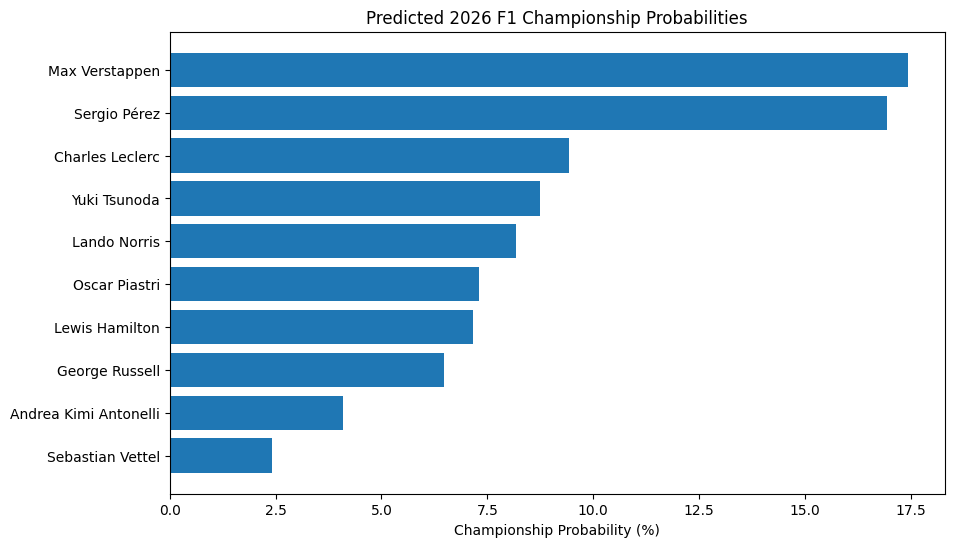

In [57]:
import matplotlib.pyplot as plt

top_10 = championship_results.head(10)

plt.figure(figsize=(10,6))
plt.barh(top_10['full_name'], top_10['championship_probability'])
plt.xlabel("Championship Probability (%)")
plt.title("Predicted 2026 F1 Championship Probabilities")
plt.gca().invert_yaxis()
plt.show()


In [58]:
results = pd.read_csv("c:/Users/DELL/Downloads/archive (11)/results.csv")
model_df = pd.read_csv("../data/final_model_data.csv")


In [59]:
race_counts = results.groupby('driver_id').size().reset_index(name='total_races')

model_df = model_df.merge(race_counts, on='driver_id', how='left')

model_df['dnf_prob'] = model_df['dnfs'] / model_df['total_races']


In [60]:
model_df[['driver_id', 'total_races', 'dnf_prob']].head()

,driver_id,total_races,dnf_prob
0,max_verstappen,55,0.0
1,perez,66,0.0
2,leclerc,40,0.0
3,tsunoda,25,0.0
4,norris,36,0.0


In [61]:
model_df.columns

Index(['driver_id', 'weighted_avg_position', 'weighted_points', 'dnfs',
       'recent_DCI', 'full_name', 'constructor_id', 'constructor_strength',
       'championship_score', 'total_races', 'dnf_prob'],
      dtype='str')

In [62]:
epsilon = 1e-6
# Convert DCI to positive scale
model_df['strength'] = model_df['recent_DCI'] - model_df['recent_DCI'].min()

# Convert to probability
model_df['win_probability'] = model_df['strength'] / model_df['strength'].sum()


In [63]:
model_df['win_probability'].sum()

np.float64(1.0)

In [64]:
model_df.columns

Index(['driver_id', 'weighted_avg_position', 'weighted_points', 'dnfs',
       'recent_DCI', 'full_name', 'constructor_id', 'constructor_strength',
       'championship_score', 'total_races', 'dnf_prob', 'strength',
       'win_probability'],
      dtype='str')

In [65]:
points_table = {
    1: 25, 2: 18, 3: 15, 4: 12, 5: 10,
    6: 8, 7: 6, 8: 4, 9: 2, 10: 1
}


In [71]:
def simulate_season(drivers_df, n_races=24):

    season_points = {driver: 0 for driver in drivers_df['driver_id']}

    for race in range(n_races):

        remaining_drivers = drivers_df.copy()
        race_order = []

        while len(remaining_drivers) > 0:

            # Recompute strength dynamically
            strengths = remaining_drivers['recent_DCI'] - remaining_drivers['recent_DCI'].min() + 1e-6
            weights = strengths / strengths.sum()

            selected = remaining_drivers.sample(n=1, weights=weights)

            race_order.append(selected.iloc[0])
            remaining_drivers = remaining_drivers.drop(selected.index)

        # Assign points
        position = 1

        for row in race_order:

            driver = row['driver_id']

            if np.random.rand() < row['dnf_prob']:
                continue

            if position <= 10:
                season_points[driver] += points_table[position]

            position += 1

    return season_points


In [72]:
champion_count = {}

for i in range(1000):
    season = simulate_season(model_df)
    champion = max(season, key=season.get)

    champion_count[champion] = champion_count.get(champion, 0) + 1


In [73]:
for driver in champion_count:
    champion_count[driver] /= 1000

champion_df = pd.DataFrame(list(champion_count.items()),
                           columns=['driverId', 'championship_probability'])

champion_df = champion_df.sort_values(by='championship_probability', ascending=False)

champion_df.head(10)


,driverId,championship_probability
4,perez,0.144
13,max_verstappen,0.139
3,leclerc,0.108
2,russell,0.081
1,sainz,0.069
7,norris,0.061
5,alonso,0.055
14,hamilton,0.051
8,vettel,0.047
11,piastri,0.047


In [76]:
champion_df = champion_df.merge(
    drivers[['driver_id', 'familyName']],
    left_on='driverId',
    right_on='driver_id',
    how='left'
)


In [77]:
champion_df[['familyName', 'championship_probability']].head(10)

,familyName,championship_probability
0,Pérez,0.144
1,Verstappen,0.139
2,Leclerc,0.108
3,Russell,0.081
4,Sainz,0.069
5,Norris,0.061
6,Alonso,0.055
7,Hamilton,0.051
8,Vettel,0.047
9,Piastri,0.047


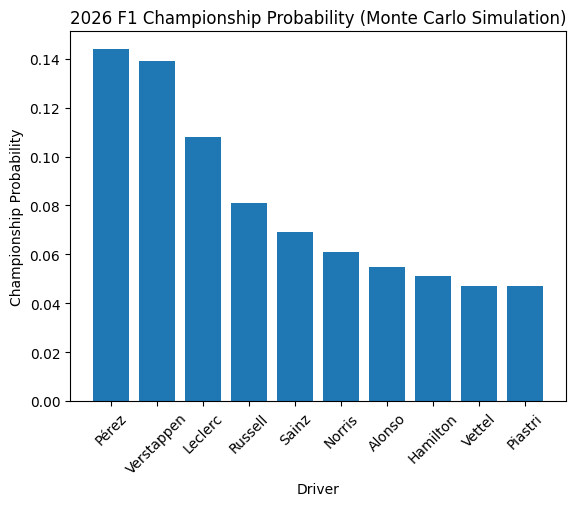

In [78]:
import matplotlib.pyplot as plt

top10 = champion_df.sort_values(
    by='championship_probability',
    ascending=False
).head(10)

plt.figure()
plt.bar(top10['familyName'], top10['championship_probability'])
plt.xticks(rotation=45)
plt.xlabel("Driver")
plt.ylabel("Championship Probability")
plt.title("2026 F1 Championship Probability (Monte Carlo Simulation)")
plt.show()


In [79]:
champion_df['championship_probability'].describe()


count    26.000000
mean      0.038462
std       0.041187
min       0.002000
25%       0.008250
50%       0.019500
75%       0.054000
max       0.144000
Name: championship_probability, dtype: float64